# Proximity Metric Evaluation Framework

Here we provide a standard implementation of our framework for the evaluation of proximity metrics in scRNA-seq data. The framework is flexible and allows user to select from a large number of proximity metrics (21), clustering performance evaluation metrics (14), as well as two clustering approaches (leiden, hierachial agglomerative) for their own evaluation. Furthermore, users can integrate other packages with our framework, to implement and evaluate other approaches to dimensionality reduction, sparsity reduction and parameter tuning.

See our ___ publication for additional details and findings of our own analysis.

### Set-up

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

import os
from scproximite import * 

import sklearn.neighbors
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
from itertools import product
import pickle

Your CPU supports instructions that this binary was not compiled to use: AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib
/Users/ariane/opt/miniconda3/envs/to_delete/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#Set random seed for reproducibility
np.random.seed(11)

#Define data directory and datasets
data_dir = '../data/framework/'

# Dataset Preparation

We begin by loading our datasets in as anndata objects containing raw counts. An anndata object can be read directly from a file (usually h5ad), or generated from an existing pandas dataframe or numpy array. Anndata objects can also be read in from files that are comma- or tab-delimited, and compressed with .zip or .gz. Here, we will read in the the four datasets selected to represent discrete-abundant, discrete-rare, continuous-abundant and continuous-rare structure.

The discrete data was produced by Wegmann et al. (2019) and is available in Zenodo, at https://zenodo.org/record/3238275. Subset 1 and 2 were produced by following the instructions included with the raw data in the Zenodo link. Additional preparation by us is included in 'Real_scRNAseq_Processing.ipynb'.

The continuous data was produced by Popescu et al. (2019) and is available at https://developmentcellatlas.ncl.ac.uk/datasets/hca_liver/data_share/. The code for producing subset 1 and subset 2 from the original dataset is provided in in 'Real_scRNAseq_Processing.ipynb'.

In [4]:
c_sub1 = sc.read_h5ad(os.path.join(data_dir,'Cellsius_Subset1_Raw.h5ad'))
c_sub2 = sc.read_h5ad(os.path.join(data_dir,'Cellsius_Subset2_Raw.h5ad'))
ery_sub1 = sc.read_h5ad(os.path.join(data_dir,'Eryth_Subset1_Raw.h5ad'))
ery_sub2 = sc.read_h5ad(os.path.join(data_dir,'Eryth_Subset2_Raw.h5ad'))

To evaluate multiple datasets simultaneously, we store them in a dictionary. If you are evaluating a single dataset, it should still be stored in a dictionary, with a single key.

In [5]:
#Set up dictionary of all datasets to be evaluated:
datasets = {
    'Discrete_Abundant': c_sub1,
    'Discrete_Rare': c_sub2,
    'Continuous_Abundant': ery_sub1,
    'Continuous_Rare': ery_sub2}    

Ensure that the ground truth cluster labels for you imported datasets are renamed to 'labels_truth', e.g. if they are currently labelled 'cell.line':

In [6]:
for dataset in datasets.keys():
    datasets[dataset].obs = datasets[dataset].obs.rename({'cell_line': 'labels_truth'}, axis='columns')

## Dataset Processing

Data processing includes:
- Filter to remove cells with > 10% mitochdonrial counts.
- Filter to remove cells with < 200 genes expressed.
- Filter to remove genes expressed in < 10% of all cells.
- Normalisation and log-transformation.

In [7]:
for dataset in datasets.keys():
    #Convert all to CSR if not already
    if sp.sparse.isspmatrix_csr(datasets[dataset].X) == False: 
        datasets[dataset].X = sp.sparse.csr_matrix(datasets[dataset].X)  
    # get useful metrics of counts data:
    datasets[dataset].var['mt'] = datasets[dataset].var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(datasets[dataset], qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    #Filter genes and cells:
    sc.pp.filter_cells(datasets[dataset], min_genes=200, inplace=True)
    sc.pp.filter_genes(datasets[dataset], min_cells=(len(datasets[dataset].obs)*0.1), inplace=True) 
    datasets[dataset] = datasets[dataset][datasets[dataset].obs.pct_counts_mt < 10, :]
    #Normalise and log-transform:
    sc.pp.normalize_total(datasets[dataset], target_sum=1e4, key_added='norm_factor')
    sc.pp.log1p(datasets[dataset])
    #Save out datasets
    #datasets[dataset].write(os.path.join(data_dir, dataset + '_Processed.h5ad')) # Save copy of processed data

/Users/ariane/opt/miniconda3/envs/to_delete/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/ariane/opt/miniconda3/envs/to_delete/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/ariane/opt/miniconda3/envs/to_delete/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/ariane/opt/miniconda3/envs/to_delete/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


### **OPTIONAL** - Producing Dimensionality-Reduced datasets

As one aspect of our investigation, we used feature selection of highly variable genes to explore the influence of dimensionality reduction on proximity metric performance for the difference data structures. Here is a code implementation where the only the 500 most highly variable genes for each dataset are retained:

If you want to perform dimensionality reduction set: `perform_dim_red`

In [8]:
perform_dim_red = False

if perform_dim_red:  
    for dataset in datasets.keys():
        sc.pp.highly_variable_genes(datasets[dataset], n_top_genes=500, min_mean=0.0125, max_mean=3, min_disp=0.5)
        datasets[dataset] = datasets[dataset][:, datasets[dataset].var.highly_variable]
        del datasets[dataset].uns
        #If you want to - save out a copy of the datasets with the python metrics distance matrices included:
        datasets[dataset].write(os.path.join(data_dir, dataset + 'HVG.h5ad'))

# Compute Distance Matrices for each Proximity Metric

Select proximity metrics to evaluate on the datasets. The full metric options are:
- **Python**: 
  - *Distances*: euclidean, cityblock (a.k.a Manhattan), canberra, chebyshev, hamming (also binary).
  - *Correlation-based*: pearson, spearman.
  - *Binary*: dice, jaccard, kulsinski, rogerstanimoto, sokalmichener, sokalsneath, yule, hamming (also distance).
  - *Proportionality-based*: braycurtis.
  - *Other*: cosine, OT (optimal transport - requires gpu and pytorch).


- **R** (see R notebooks): 
  - *Proportionality-based*: phi, rho.
  - *Correlation-based*: kendall, ZI-kendall (Zero-Inflated), weighted-rank.
  
**Warning**: ZI-Kendall and OT are highly computationally expensive, and can take several hours to run.

In [9]:
py_metrics = ['euclidean', 'cityblock','braycurtis']

In [10]:
for dataset in datasets.keys():
    for metric in py_metrics:
        proximity_matrix(data=datasets[dataset].X, anndata=datasets[dataset], metric=metric, save_rep=f'{metric}_matrix')
    #If you want to - save out a copy of the datasets with the python metrics distance matrices included:
    datasets[dataset].write(os.path.join(data_dir, dataset +'_Metrics.h5ad')) 

### **OPTIONAL** - Merging distance matrices from R with python metrics in anndata object

If you want to evaluate any of the metrics implemented in R, you can convert your processed data anndata object to a seurat object (Convert_H5AD_to_RDS.ipynb) and compute the metrics using the dismay package implementations (Proximity_Metrics_R.ipynb). These matrices will be outputted as .csv files, which can be merged into the anndata object containing the distance matrices for the python proximity metrics here:

To do this you need to first set `run_r=True`.

In [11]:
run_r = False
if run_r:
    r_metrics = ['phi_s', 'kendall']
    for dataset in datasets.keys():
        for metric in r_metrics:
            mat = pd.read_csv(os.path.join(data_dir, dataset + f'_{metric}_.csv'),index_col=0, header=0).values
            merge_metrics(mat, datasets[dataset], metric)
        ##If you want to - save out a copy of the datasets with all distance matrices included:
        #datasets[dataset].write(os.path.join(data_dir, dataset +'Metrics_Merged.h5ad')) 
else:
    r_metrics = []

# Compute K-Nearest Neighbour Graphs for each Proximity Metric

**Note** - If using Hierachial agglomerative clustering, this step can be skipped.

K-Nearest Neighbour (KNN) connectivity graphs must be computed from the distance matrices to perform graph-based clustering. The value of k selected for a graph represents the number of close 'neighbours' that will be identified for each cell. A seperate graph will be produced for each k value listed, for each of the proximity metrics under evaluation.

In [12]:
#Select neighbourhood sizes to evaluate:
k_vals = [5,30,50,100]
metrics = r_metrics + py_metrics

In [13]:
for dataset in datasets.keys():
    for metric, k in product(metrics, k_vals):
        datasets[dataset].obsp[f'{metric}_{k}KNNG'] = sklearn.neighbors.kneighbors_graph(datasets[dataset].obsp[f'{metric}_matrix'],
                                                     n_neighbors=k, metric="precomputed", mode="connectivity", include_self=False, n_jobs=-1)
    #If you want to - save out a copy of the datasets with the distance matrices included:
    #new_dat = datasets[dataset].copy()
    #new_dat.write(os.path.join(data_dir, dataset + '_KNNG.h5ad'))

# Perform Clustering and Evaluation

We have implemented two clustering approaches:
- Leiden Clustering (scanpy implementation) ('leiden')
- Hierarchical Agglomerative Clustering (scikit learn implementation) ('agglomerative')

For evaluation of metric performance, the user can select as many options as they would like from:

*External Validation Metrics*:
- Pair Sets Index (PSI)
- Adujusted Rand Index (ARI)
- Normalised Mutual Information (NMI)
- Adjusted Mutual Information (AMI)
- Jaccards Index (Jac)
- Homogeneity Score (HS)
- Completeness Score (CS)
- Fowlkes-Mallows (FM)
- Matthews correlation coefficient (MCC)

*Internal Validation Metrics*:
- Silhouette Score (SIL)
- Variance Ratio Criterion (a.k.a Calinski and Harabasz score) (VRC)
- Davies-Bouldin score (DBS)

*Additional*:
- Paired Confusion Matrix (CFM)
- Contingency Matric (CGM)

All metrics are implemented from scikit learn.

In [14]:
# Select evaluation metrics for clustering performance:
eval_metrics = ['PSI','ARI']

As clustering output may change based on initialisation, clustering is repeated multiple times and an average of the evaluation scores taken as the final clustering performance. We utilised 10 iterations of clustering for our study, but this may be adjusted as the user would like:

In [15]:
# Generate a number of random seeds for clustering initialisation (we have reduced this to 5 for the tutorial)
random_seeds = np.random.randint(100, size = 5)
print(random_seeds)

[25 63 80 91 81]


## Leiden - Graph based clustering

In [16]:
# Select clustering method:
clustering_method = 'leiden'

In [19]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

for dataset in datasets.keys():
    for seed in random_seeds:
        met_dict = dict.fromkeys(metrics)
        k_dict = dict.fromkeys(k_vals)
        for k in k_vals:
            k_dict[k] = {}
            for metric in metrics:
                clustering(anndata=datasets[dataset], graph=datasets[dataset].obsp[f'{metric}_{k}KNNG'],
                           method=clustering_method, save_rep=f'{metric}_{clustering_method}{k}k',
                           optimisation_labs=datasets[dataset].obs['labels_truth'], rs=seed)
                k_dict[k][metric] = cluster_stats(datasets[dataset], labels_true=datasets[dataset].obs['labels_truth'],
                                                labels_pred=datasets[dataset].obs[f'{metric}_{clustering_method}{k}k'],
                                                    prox_metric=metric, eval_list=eval_metrics)
            datasets[dataset].uns[f'{k}K_stats'] = k_dict[k]
        del datasets[dataset].uns['leiden']
        new_dat = datasets[dataset].copy()
        new_dat.write(os.path.join(data_dir, dataset + f'_Clust_{seed}.h5ad')) #These datasets need to be saved out, to load in for merging.

## Hierachial Agglomerative Clustering

If you want to run an alternative version of clustering set: `alt_clustering=True`

In [20]:
# Set this if you want alt
alt_clustering = False


if alt_clustering:
    # Select clustering method
    clustering_method = 'agglomerative'
    
    for dataset in datasets.keys():
        for seed in random_seeds:
            met_dict = dict.fromkeys(metrics)
            k_dict = dict.fromkeys(k_vals, met_dict)
            for k in k_vals:
                for metric in metrics:
                    clustering(anndata=datasets[dataset], prox_matrix=datasets[dataset].obsp[f'{metric}_matrix'],
                               method=clustering_method, save_rep=f'{metric}_{clustering_method}{k}k',
                               optimisation_labs=datasets[dataset].obs['labels_truth'], rs=seed)
                    k_dict[k][metric] = cluster_stats(datasets[dataset], labels_true=datasets[dataset].obs['labels_truth'],
                                                    labels_pred=datasets[dataset].obs[f'{metric}_{clustering_method}{k}k'],
                                                        prox_metric=metric, eval_list=eval_metrics)
                datasets[dataset].uns[f'{k}K_stats'] = k_dict[k]
            new_dat = datasets[dataset].copy()
            new_dat.write(os.path.join(data_dir, dataset + f'_Clust_{seed}.h5ad')) #These datasets need to be saved out, to load in for merging.

# Merge Results

Clustering performance results from all iterations are merged into a single nested dictionary for each of the datasets to minimise strain on computation resources. This file is automatically saved out using pickle, and if save_as_csv=True, a dataframe with the compelte set of evaluation results for each dataset will be saved out as a .csv file as well.

In [21]:
#Set up new dictionary to store merged evaluation results
evaluations = dict.fromkeys(['Discrete_Abundant','Discrete_Rare','Continuous_Abundant','Continuous_Rare'], None) 

In [22]:
for dataset in evaluations.keys():
    evaluations[dataset] = merge_evaluations(anndata=dataset, metrics=metrics,k_vals=k_vals,eval_metrics=eval_metrics,
                      clustering_method=clustering_method,data_dir=data_dir,random_seeds=random_seeds, save_as_csv=True)

# Significance testing for performance at different neighbourhood sizes

## Kruskal-Wallis test

Kruskal-Wallis is a non-parametric version of ANOVA, and tests the null hypothesis that the population median of all of the groups are equal. Requires 2 or more independent samples, which may have different sizes.

In [23]:
for dataset in evaluations.keys():
    evaluations[dataset] = reform(evaluations[dataset], levels = ['Eval', 'Metric', 'k_val']) #Reform nested dictionary of evaluation results into multi-index pandas dataframes
    evaluations[dataset] = kruskal_test(data=evaluations[dataset], anndata=dataset, metrics=metrics, eval_metrics=eval_metrics, k_vals=k_vals, data_dir=data_dir, random_seeds=random_seeds)

/Users/ariane/opt/miniconda3/envs/to_delete/lib/python3.8/site-packages/scproximite/funcs.py:407: PerformanceWarning: indexing past lexsort depth may impact performance.
  data.loc[(eval_m, metric), 'kruskal'] = krusk


    euclidean cityblock braycurtis
PSI  0.000315  0.000273   0.000273
ARI  0.000315  0.000273   0.000273


/Users/ariane/opt/miniconda3/envs/to_delete/lib/python3.8/site-packages/scproximite/funcs.py:407: PerformanceWarning: indexing past lexsort depth may impact performance.
  data.loc[(eval_m, metric), 'kruskal'] = krusk


    euclidean cityblock braycurtis
PSI  0.001118  0.000503   0.000468
ARI  0.098841  0.001504   0.000468


/Users/ariane/opt/miniconda3/envs/to_delete/lib/python3.8/site-packages/scproximite/funcs.py:407: PerformanceWarning: indexing past lexsort depth may impact performance.
  data.loc[(eval_m, metric), 'kruskal'] = krusk


    euclidean cityblock braycurtis
PSI  0.001562  0.004486   0.000529
ARI  0.009544  0.011949   0.001423


/Users/ariane/opt/miniconda3/envs/to_delete/lib/python3.8/site-packages/scproximite/funcs.py:407: PerformanceWarning: indexing past lexsort depth may impact performance.
  data.loc[(eval_m, metric), 'kruskal'] = krusk


    euclidean cityblock braycurtis
PSI  0.019008  0.003156   0.201294
ARI  0.300246  0.029443   0.787429


## Dunn test

A post-hoc test for multiple comparisons of mean rank sums, can be used after Kruskal-Wallis for pairwise comparisons to identify exactly which neighbourhood sizes differ signicantly.

In [24]:
#Filter datasets to only include metrics deemed to have significant differences between neighbourhood sizes by Kruskal-Wallis.
for dataset in evaluations.keys():
    evaluations[dataset] = evaluations[dataset][evaluations[dataset]['kruskal']<0.05]

Dunn test results for euclidean in Discrete_Abundant:             5K_stats  30K_stats  50K_stats  100K_stats
5K_stats    1.000000   0.000245   0.514398    0.031189
30K_stats   0.000245   1.000000   0.031189    0.514398
50K_stats   0.514398   0.031189   1.000000    0.514398
100K_stats  0.031189   0.514398   0.514398    1.000000


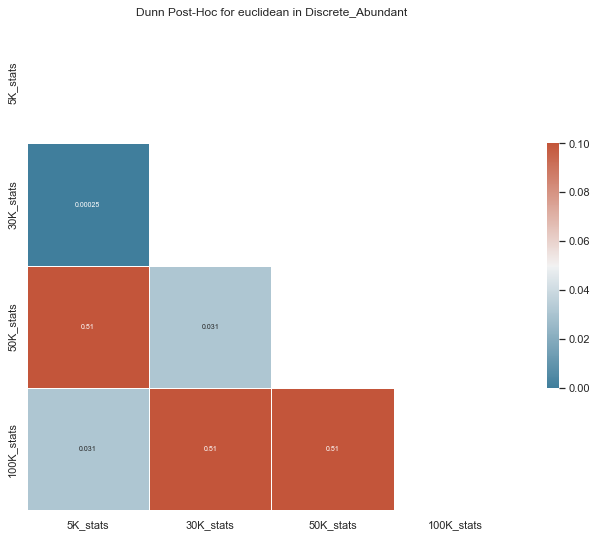

Dunn test results for cityblock in Discrete_Abundant:             5K_stats  30K_stats  50K_stats  100K_stats
5K_stats    1.000000   1.000000   1.000000    0.002233
30K_stats   1.000000   1.000000   1.000000    0.002233
50K_stats   1.000000   1.000000   1.000000    0.002233
100K_stats  0.002233   0.002233   0.002233    1.000000


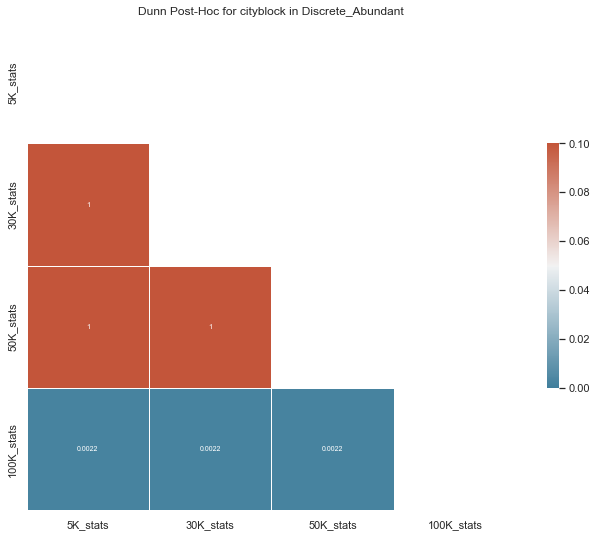

Dunn test results for braycurtis in Discrete_Abundant:             5K_stats  30K_stats  50K_stats  100K_stats
5K_stats    1.000000   0.504235   0.029184    0.000213
30K_stats   0.504235   1.000000   0.504235    0.029184
50K_stats   0.029184   0.504235   1.000000    0.504235
100K_stats  0.000213   0.029184   0.504235    1.000000


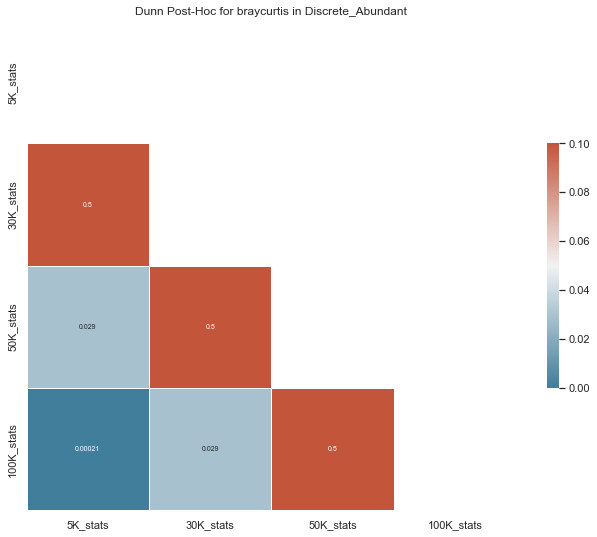

Dunn test results for euclidean in Discrete_Abundant:             5K_stats  30K_stats  50K_stats  100K_stats
5K_stats    1.000000   0.000245   0.514398    0.031189
30K_stats   0.000245   1.000000   0.031189    0.514398
50K_stats   0.514398   0.031189   1.000000    0.514398
100K_stats  0.031189   0.514398   0.514398    1.000000


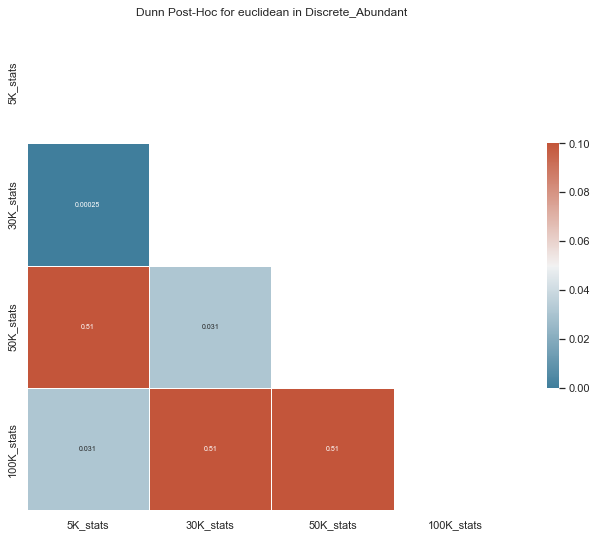

Dunn test results for cityblock in Discrete_Abundant:             5K_stats  30K_stats  50K_stats  100K_stats
5K_stats    1.000000   1.000000   1.000000    0.002233
30K_stats   1.000000   1.000000   1.000000    0.002233
50K_stats   1.000000   1.000000   1.000000    0.002233
100K_stats  0.002233   0.002233   0.002233    1.000000


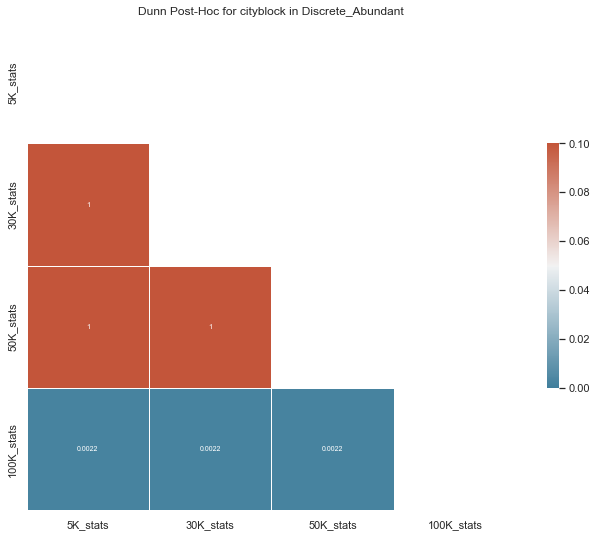

Dunn test results for braycurtis in Discrete_Abundant:             5K_stats  30K_stats  50K_stats  100K_stats
5K_stats    1.000000   0.504235   0.029184    0.000213
30K_stats   0.504235   1.000000   0.504235    0.029184
50K_stats   0.029184   0.504235   1.000000    0.504235
100K_stats  0.000213   0.029184   0.504235    1.000000


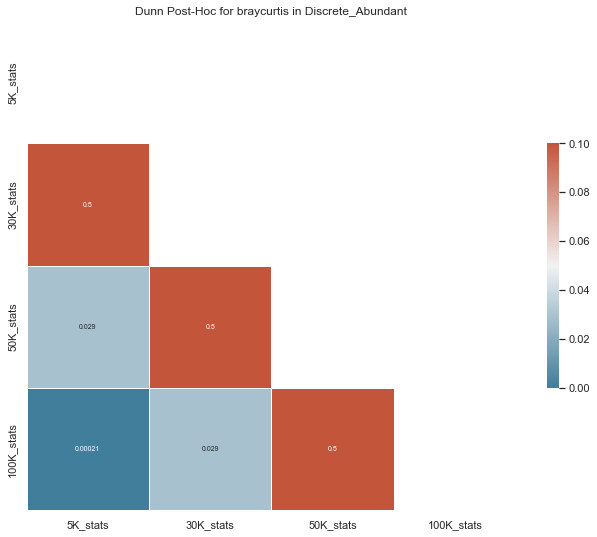

Dunn test results for euclidean in Discrete_Rare:             5K_stats  30K_stats  50K_stats  100K_stats
5K_stats    1.000000   0.437149   0.085753    0.000704
30K_stats   0.437149   1.000000   0.437149    0.043819
50K_stats   0.085753   0.437149   1.000000    0.362502
100K_stats  0.000704   0.043819   0.362502    1.000000


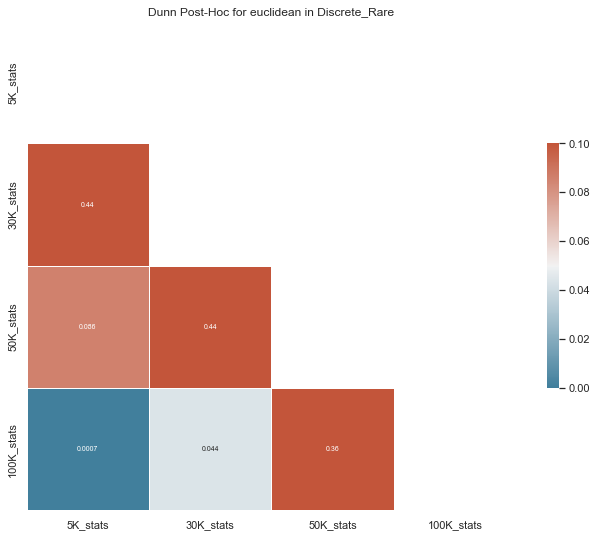

Dunn test results for cityblock in Discrete_Rare:             5K_stats  30K_stats  50K_stats  100K_stats
5K_stats    1.000000   0.489036   0.042810    0.000343
30K_stats   0.489036   1.000000   0.489036    0.042810
50K_stats   0.042810   0.489036   1.000000    0.489036
100K_stats  0.000343   0.042810   0.489036    1.000000


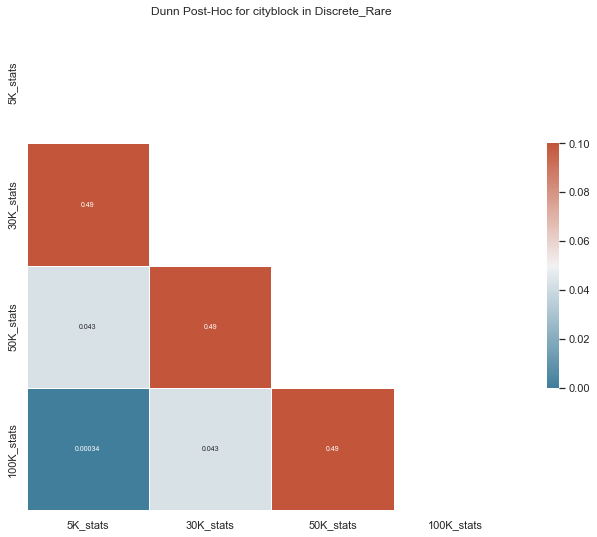

Dunn test results for braycurtis in Discrete_Rare:             5K_stats  30K_stats  50K_stats  100K_stats
5K_stats    1.000000   0.543855   0.037519    0.000364
30K_stats   0.543855   1.000000   0.543855    0.037519
50K_stats   0.037519   0.543855   1.000000    0.543855
100K_stats  0.000364   0.037519   0.543855    1.000000


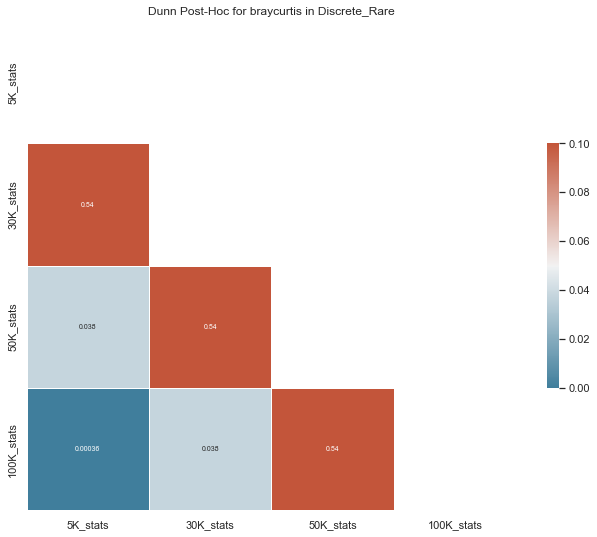

Dunn test results for cityblock in Discrete_Rare:             5K_stats  30K_stats  50K_stats  100K_stats
5K_stats    1.000000   0.566464   0.127437    0.001037
30K_stats   0.566464   1.000000   0.566464    0.036513
50K_stats   0.127437   0.566464   1.000000    0.322436
100K_stats  0.001037   0.036513   0.322436    1.000000


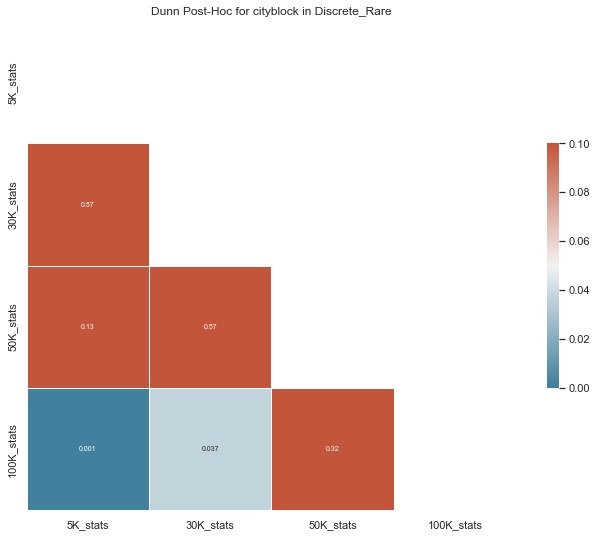

Dunn test results for braycurtis in Discrete_Rare:             5K_stats  30K_stats  50K_stats  100K_stats
5K_stats    1.000000   0.543855   0.037519    0.000364
30K_stats   0.543855   1.000000   0.543855    0.037519
50K_stats   0.037519   0.543855   1.000000    0.543855
100K_stats  0.000364   0.037519   0.543855    1.000000


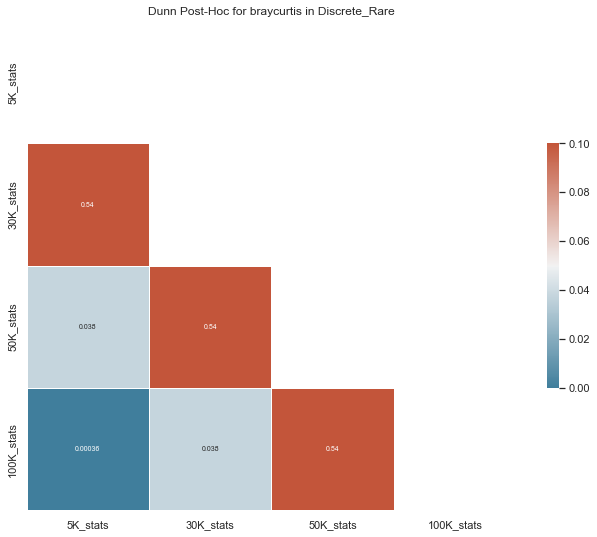

Dunn test results for euclidean in Continuous_Abundant:             5K_stats  30K_stats  50K_stats  100K_stats
5K_stats    1.000000   0.000559   0.190493    0.161244
30K_stats   0.000559   1.000000   0.190493    0.190493
50K_stats   0.190493   0.190493   1.000000    0.872410
100K_stats  0.161244   0.190493   0.872410    1.000000


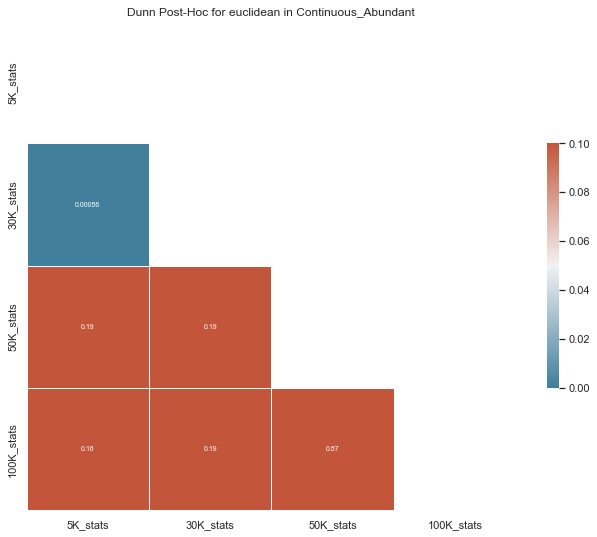

Dunn test results for cityblock in Continuous_Abundant:             5K_stats  30K_stats  50K_stats  100K_stats
5K_stats    1.000000   0.056810   0.162777    0.002783
30K_stats   0.056810   1.000000   0.664634    0.664634
50K_stats   0.162777   0.664634   1.000000    0.437684
100K_stats  0.002783   0.664634   0.437684    1.000000


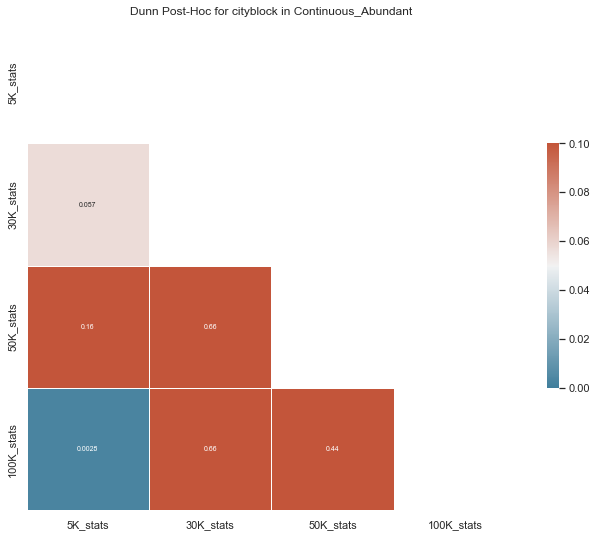

Dunn test results for braycurtis in Continuous_Abundant:             5K_stats  30K_stats  50K_stats  100K_stats
5K_stats    1.000000   0.437223   0.048519    0.000319
30K_stats   0.437223   1.000000   0.437223    0.048519
50K_stats   0.048519   0.437223   1.000000    0.437223
100K_stats  0.000319   0.048519   0.437223    1.000000


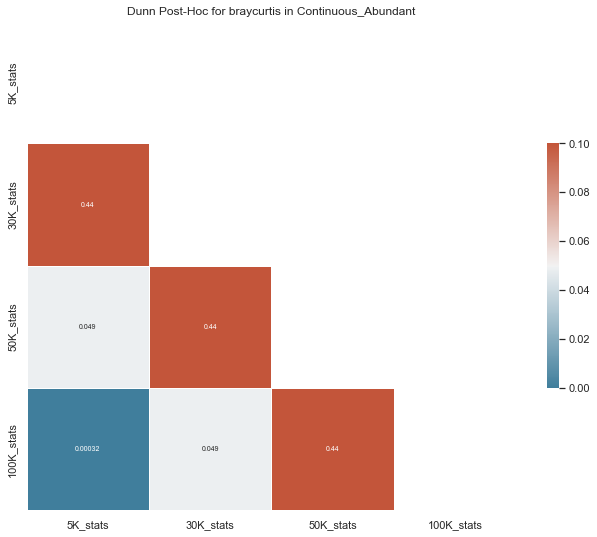

Dunn test results for euclidean in Continuous_Abundant:             5K_stats  30K_stats  50K_stats  100K_stats
5K_stats    1.000000   0.542376   0.542376    0.068984
30K_stats   0.542376   1.000000   0.274966    0.009517
50K_stats   0.542376   0.274966   1.000000    0.542376
100K_stats  0.068984   0.009517   0.542376    1.000000


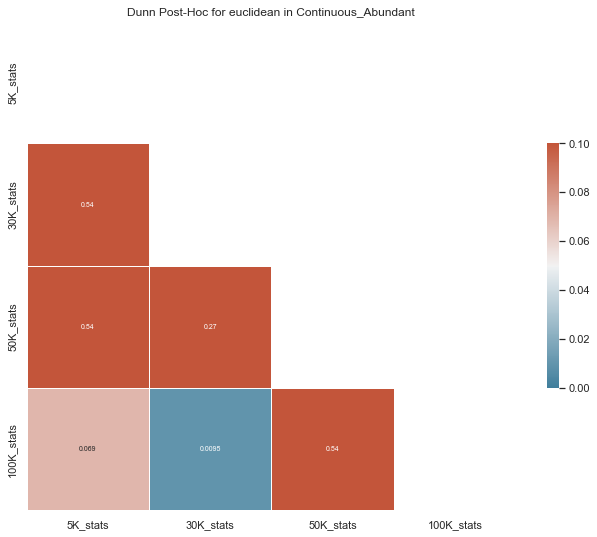

Dunn test results for cityblock in Continuous_Abundant:             5K_stats  30K_stats  50K_stats  100K_stats
5K_stats    1.000000   0.007388   0.646313    0.646313
30K_stats   0.007388   1.000000   0.136149    0.185145
50K_stats   0.646313   0.136149   1.000000    0.829428
100K_stats  0.646313   0.185145   0.829428    1.000000


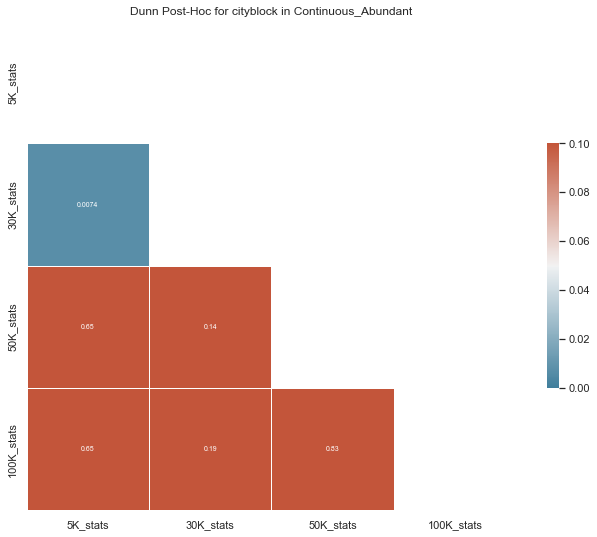

Dunn test results for braycurtis in Continuous_Abundant:             5K_stats  30K_stats  50K_stats  100K_stats
5K_stats    1.000000   0.394187   0.001838    0.015215
30K_stats   0.394187   1.000000   0.142461    0.394187
50K_stats   0.001838   0.142461   1.000000    0.517922
100K_stats  0.015215   0.394187   0.517922    1.000000


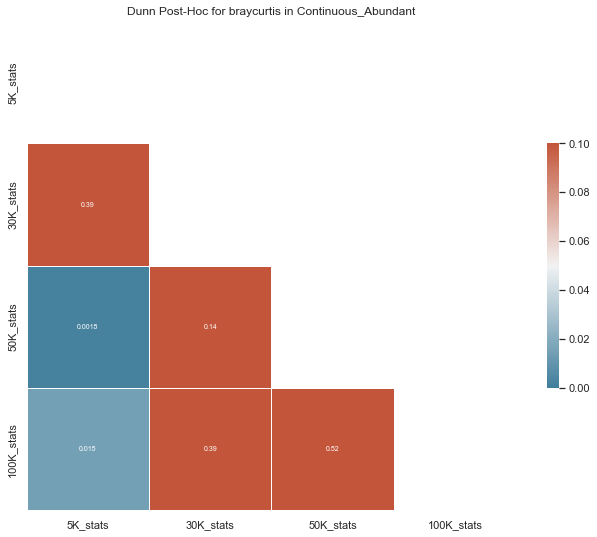

Dunn test results for euclidean in Continuous_Rare:             5K_stats  30K_stats  50K_stats  100K_stats
5K_stats    1.000000   0.099074   0.059981    0.027671
30K_stats   0.099074   1.000000   1.000000    1.000000
50K_stats   0.059981   1.000000   1.000000    1.000000
100K_stats  0.027671   1.000000   1.000000    1.000000


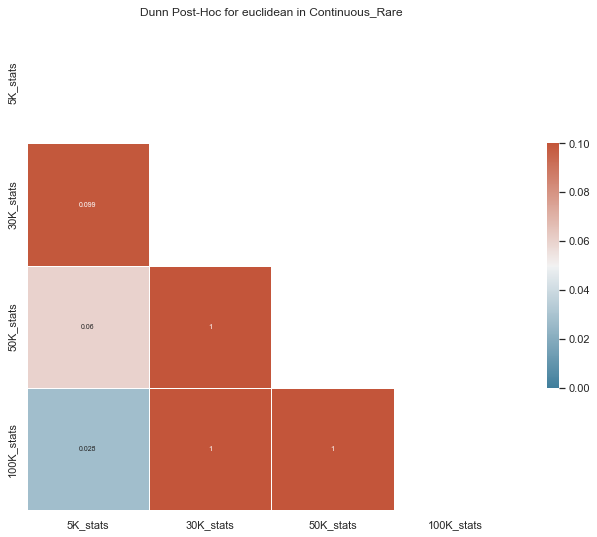

Dunn test results for cityblock in Continuous_Rare:             5K_stats  30K_stats  50K_stats  100K_stats
5K_stats    1.000000   1.000000    0.05576    0.032664
30K_stats   1.000000   1.000000    0.05576    0.032664
50K_stats   0.055760   0.055760    1.00000    1.000000
100K_stats  0.032664   0.032664    1.00000    1.000000


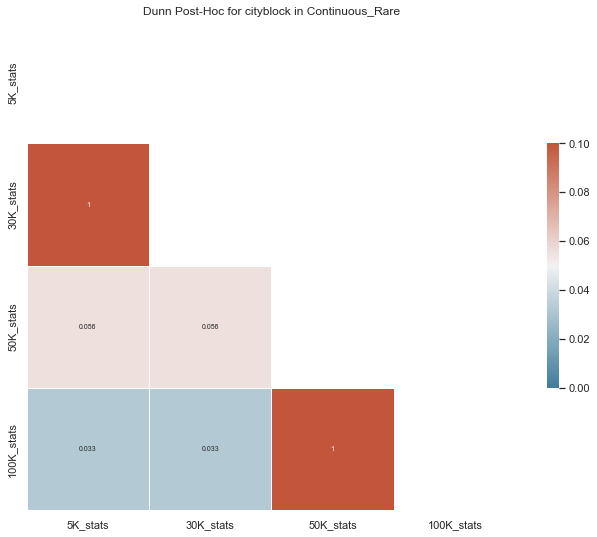

Dunn test results for cityblock in Continuous_Rare:             5K_stats  30K_stats  50K_stats  100K_stats
5K_stats    1.000000   1.000000   0.107682    0.245475
30K_stats   1.000000   1.000000   0.096942    0.245475
50K_stats   0.107682   0.096942   1.000000    1.000000
100K_stats  0.245475   0.245475   1.000000    1.000000


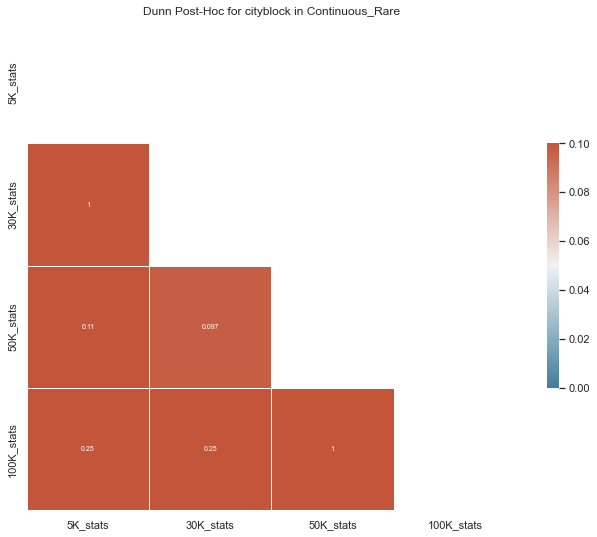

In [25]:
for dataset in evaluations.keys():
    try:
        dunn_test(data=evaluations[dataset], anndata=dataset, metrics=metrics,eval_metrics=eval_metrics,
              k_vals=k_vals, random_seeds=random_seeds, printout=True,visualise=True,save=False, data_dir=data_dir)
    except:
        print(f'Dataset: {dataset}, with none < 0.05')
        
        